# モニタリング（研究データ容量）

研究データ容量について、DMPに記載された上限を超過していないかモニタリングします。  
以下のセルを上から実行してください。2回目以降の実行では、画面上部に表示される以下のボタンをクリックしてから実行して下さい。  
![UnfreezeBotton](https://raw.githubusercontent.com/NII-DG/workflow-template/develop/sections/images/unfreeze_button.png)
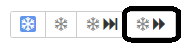

## 1. 基準値となるデータ容量上限値を取得する

In [ ]:
import os
import json

os.chdir('..')
from util.scripts import utils 

path_params = utils.fetch_monitoring_param_file_path()
limit = ""
with open(path_params, "r") as f:
    dmp = json.load(f)
    limit = dmp["dataSize"]

In [ ]:
print("input : " + str(limit))

if isinstance(limit, str):  # "100", "100B", "100b", "100KB", "100kb"
    limit = limit.lower()

    if limit[-1] == "b":
        limit = limit[:-1]

    units = ["k", "m", "g", "t", "p", "e", "z"]
    if limit[-1] in units:
        limit = 1024 ** (units.index(limit[-1]) + 1) * int(limit[:-1])

print("output: " + str(limit))


## 2. 実験パッケージ情報を取得する

In [ ]:
import os
import json
import glob

# 作業ディレクトリに移動
%cd ~/experiments/

# 実験パッケージ群の読み込み
dirs = glob.glob("./*/")

experiments = []
for dir_name in dirs:
    experiments += [os.path.basename(dir_name[:-1])]
print("実験パッケージ　：" + str(experiments))

# 元のディレクトリに移動
%cd -

## 3. 各実験パッケージについて実データを取得する

In [ ]:
for experiment in experiments:
    %cd ~/experiments/$experiment
    !git pull
    !datalad get -r .
    %cd ../

## 4. データ容量をチェックする

In [ ]:
isSucceeded = True

result = !du -s ~/experiments/
result = result[0].split("\t")[0]
result = int(result)
print("datasize: " + str(result))

if result > limit:
    isSucceeded = False
    raise Exception("データ容量を超過しています")

## 4. モニタリング結果をREADMEに反映する

In [ ]:
from util.scripts import utils

utils.reflect_monitoring_results('dataAmount', isSucceeded)

## 5. 実行結果をデータガバナンス機能に同期する

ここまでの内容を保存し、データガバナンス機能に同期します。  
以下のセルを実行してください。

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

In [ ]:
import papermill as pm

%cd ~/

pm.execute_notebook(
    'WORKFLOW/FLOW/util/base_datalad_save_push.ipynb',
    '/home/jovyan/.local/push_log.ipynb',
    parameters = dict(SAVE_MESSAGE = 'モニタリング（研究データ容量）', IS_RECURSIVE = False, TO_GIT = True)
)

## 6. FLOWに遷移する

続けてワークフローを実行する場合は、[こちら](../base_FLOW.ipynb)からFLOWに遷移できます。